In [24]:
# %%
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import joblib
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')
%matplotlib inline


In [25]:
# %%
import random
import numpy as np
import tensorflow as tf

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [26]:
# %%
# Load dataset
df = pd.read_csv('recruitment_data.csv')

# Define the features and the target class
x = df.drop(columns=['HiringDecision'], axis=1)
y = df['HiringDecision']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)


In [27]:
# %%
# Load the saved models
model_paths = [
    'best_svm_model.pkl',
    'catBoost1model.pkl',
    'best_knn_model.pkl',
    'LR_model_imb.pkl',
    'best_gnb_model.pkl',
    'RFmodel.pkl',
    'xgbimba.pkl',
    'DTmodel89.pkl'
]

models = []
for path in model_paths:
    try:
        model = joblib.load(path)
        if hasattr(model, 'fit'):
            models.append(model)
        else:
            print(f"Error: Loaded object from {path} is not a valid model.")
    except ModuleNotFoundError as e:
        print(f"ModuleNotFoundError for {path}: {e}")

model_names = [f'model_{i+1}' for i in range(len(models))]
estimators = list(zip(model_names, models))


In [28]:
# %%
# Define possible voting schemes
voting_schemes = ['hard', 'soft']


In [29]:
# %%
best_combination = None
best_voting_scheme = None
best_score = 0

# Iterate over all possible combinations of models with at least 3 models
for L in range(3, len(estimators) + 1):
    for subset in itertools.combinations(estimators, L):
        # Iterate over all voting schemes
        for voting in voting_schemes:
            try:
                voting_clf = VotingClassifier(
                    estimators=list(subset),
                    voting=voting
                )
                voting_clf.fit(x_train, y_train)
                y_pred_test = voting_clf.predict(x_test)
                test_accuracy = accuracy_score(y_test, y_pred_test) * 100

                if test_accuracy > best_score:
                    best_score = test_accuracy
                    best_combination = subset
                    best_voting_scheme = voting

                print(f"Test Accuracy with voting={voting} and models {subset}: {test_accuracy:.2f}%")
            except Exception as e:
                print(f"Failed with voting={voting} and models {subset}: {e}")

print(f"Best Test Accuracy: {best_score:.2f}% with voting={best_voting_scheme} and models {best_combination}")


Test Accuracy with voting=hard and models (('model_1', Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                ('svc',
                 SVC(C=0.1, gamma=1, kernel='linear', probability=True))])), ('model_2', <catboost.core.CatBoostClassifier object at 0x00000239B4829C90>), ('model_3', Pipeline(steps=[('selectkbest', SelectKBest(k=1)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))]))): 91.33%
Test Accuracy with voting=soft and models (('model_1', Pipeline(steps=[('selectkbest', SelectKBest(k=7)),
                ('svc',
                 SVC(C=0.1, gamma=1, kernel='linear', probability=True))])), ('model_2', <catboost.core.CatBoostClassifier object at 0x00000239B4829C90>), ('model_3', Pipeline(steps=[('selectkbest', SelectKBest(k=1)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))]))): 92.22%
Failed with voting=hard and models (('model_1', Pipeline(steps=[('selectkbest', Sele

Accuracy:  96.22222222222221
Recall:  96.22222222222221
Precision:  96.21454451345755
F1-Score:  96.2178100788094


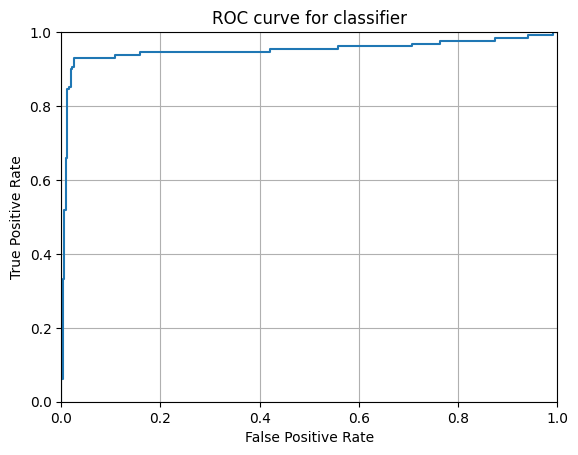

AUC Score: 0.9498176724866575
Loaded model accuracy: 96.22222222222221
VotingClassifier(estimators=[('model_2',
                              <catboost.core.CatBoostClassifier object at 0x00000239B2973CD0>),
                             ('model_3',
                              Pipeline(steps=[('selectkbest', SelectKBest(k=1)),
                                              ('knn',
                                               KNeighborsClassifier(metric='euclidean',
                                                                    n_neighbors=3))])),
                             ('model_6',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=50,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=500,
                                            

In [30]:
# %%
# Evaluate the best model
voting_clf = VotingClassifier(
    estimators=list(best_combination),
    voting=best_voting_scheme
)
voting_clf.fit(x_train, y_train)
y_pred_test = voting_clf.predict(x_test)

print('Accuracy: ', accuracy_score(y_test, y_pred_test) * 100)
print('Recall: ', recall_score(y_test, y_pred_test, average='weighted') * 100)
print('Precision: ', precision_score(y_test, y_pred_test, average='weighted') * 100)
print('F1-Score: ', f1_score(y_test, y_pred_test, average='weighted') * 100)

if best_voting_scheme == 'soft':
    # Compute ROC curve and AUC score
    y_pred_prob = voting_clf.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

    print("AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Save the best model
joblib_file = "best_voting_model.pkl"
joblib.dump(voting_clf, joblib_file)

# Load and test the saved model
loaded_model = joblib.load(joblib_file)
print('Loaded model accuracy:', accuracy_score(y_test, loaded_model.predict(x_test)) * 100)
print(loaded_model)


<Figure size 800x600 with 0 Axes>

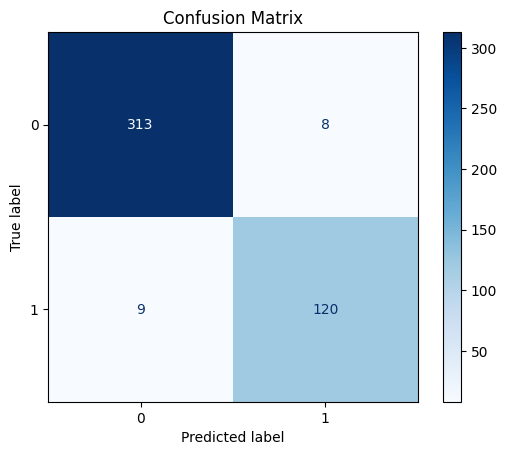

In [31]:
# %%
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=voting_clf.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [32]:
import winsound

# Play a sound to indicate the end of the process
winsound.MessageBeep()
